In [1]:
import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
from scipy.interpolate import interp1d

In [2]:
#FOR VERTEX:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [3]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [20]:
def s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K):
    "returns the annealed disorder average of the 2 point sf inverse of a binary mixture of diblock copolymers"
    "CURRENTLY ONLY HANDLES POLYS OF SAME LENGTH"
    if (N_1 != N_2):
        raise Exception("Can only handle binary mix of polymers with same length")
        
    if norm(K) < 1e-5:
        s2inv = s2inverse_zeroq_polyd(N_1, N_2, PHI_1, PHI_2) #TODO change so handles dif length polys
        return s2inv
    
    #PHI_2 = 1 - PHI_1
    s2_1 = s2wlc(pset, N_1, FA_1, K)
    s2_2 = s2wlc(pset, N_2, FA_2, K)
    
    s2inv = np.zeros((2,2),dtype=type(1+1j))
    
    [s2aa_1, s2ab_1], [s2ba_1, s2bb_1] = s2_1
    [s2aa_2, s2ab_2], [s2ba_2, s2bb_2] = s2_2
    
    s2aa = PHI_1*s2aa_1+PHI_2*s2aa_2 # TODO: update these averages to consider N_1 != N_2
    s2ab = PHI_1*s2ab_1+PHI_2*s2ab_2
    s2ba = PHI_1*s2ba_1+PHI_2*s2ba_2
    s2bb = PHI_1*s2bb_1+PHI_2*s2bb_2
    
    det = s2aa*s2bb - s2ab*s2ba
    
    s2inv[0,0] = s2bb/det
    s2inv[0,1] = -s2ab/det
    s2inv[1,0] = -s2ba/det
    s2inv[1,1] = s2aa/det
    
    return s2inv

In [25]:
def spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2):
    CHI = 0
    if (N_1 != N_2):
        raise Exception("Can only handle binary mix of polymers with same length")
    K0 = 1/np.sqrt(r2(N_1))
    
    KS = optimize.fmin(lambda K: np.real(gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K, CHI)), K0,\
                      disp=False)
    
    return KS

In [22]:
# chemically averaged

def gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K, CHI):
    #Only accepts two polymer types of same length
    #PHI_2 = 1 - PHI_1
    
    s2inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K)

    D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += s2inv[I0, I1]*D[I0]*D[I1]
        
    return -2*CHI + (PHI_1*N_1 + PHI_2*N_2)*G #TODO: fix this averaging for polys w different length
# calc spinodal!

In [23]:
def s2inverse_zeroq_polyd(N_1, N_2, PHI_1, PHI_2):
    s2 = np.ones((2,2),dtype='complex')
    N_ave = N_1 * PHI_1 + N_2 * PHI_2
    return s2/(N_ave**2)

In [13]:
N_1 = 10.

FA_1_arr = np.arange(0.3, 0.71, 0.1)
chi_range = np.arange(8, 20, .01)/N_1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


# Monodisperse 

In [14]:
%%time
#single component G2 matrix stability analysis, POST INCOMPRESSIBILITY

spinodal_arr = np.array([]) 

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]
    for chi in chi_range:
        chi_spin_bool = False #means spinodal has not been reached
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2 #determinant of s2 matrix
            prefactor_1 = 1/(det_1)[0] #1/2 from taylor expansion, which remains after performing gaussian integral

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1
            
            G2 = (s2inv_AA_1 + 2*s2inv_AB_1 + s2inv_BB_1)-2*chi*N_1
            if G2 <= 0:
                chi_spin_bool = True
                break
        if chi_spin_bool == True:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

Wall time: 28.6 s


In [15]:
%%time
#single component Vertex spinodal


#generate spinodal
# N = N_1
# f_as = FA_1_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(FA_1_arr))
for i, FA in enumerate(FA_1_arr):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal(pset, N_1, FA)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2(pset, N_1, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 10.7 s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

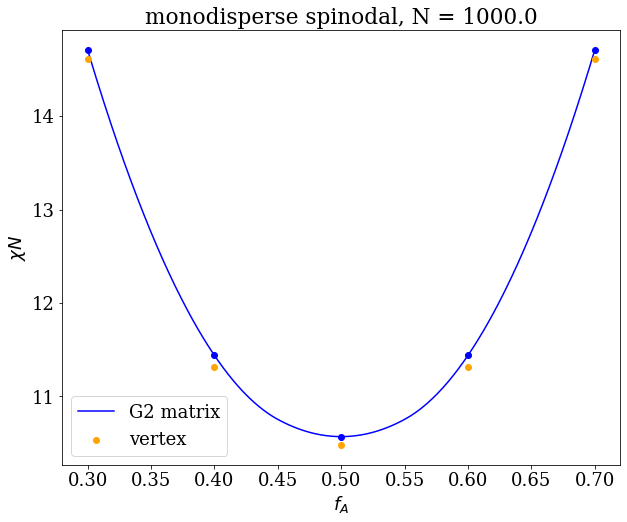

In [16]:
matrixG2_spin_mono_interp = interp1d(FA_1_arr, spinodal_arr, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic") 

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.301, 0.7, 0.001)
ax.plot(new_x, matrixG2_spin_mono_interp(new_x), color = "blue", label = "G2 matrix", zorder=1)
# ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "orange", label = "vertex")

ax.scatter(FA_1_arr, spinodal_arr, color = "blue", zorder = 2)
ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "orange", label = "vertex", zorder = 3)
plt.legend()
plt.title("monodisperse spinodal, N = " + str(N_1))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

# Polydisperse binary mix

In [63]:
N_1 = 10.
FA_1_arr = np.arange(0.1, 0.701, 0.1)
PHI_1 = 0.5

N_2 = N_1
FA_2 = 0.7
PHI_2 = 0.5

k0 = 1e-2
kf = 1e2
nk = 50

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

chi_range = np.arange(4, 20, 0.01)/N_1

In [147]:
arr_1 = []
arr_2 = np.array([3, 4], dtype = object)
arr_1.append([3, 4])
arr_1.append([5, 6])
arr_1

[[3, 4], [5, 6]]

In [153]:
%%time
#binary mix- Vectorized, ASSUMING SAME LENGTH
#TODO- interpreting eigenvalues


# chi_range = np.arange(5.5, 20, 0.001)/N_1


polyd_spinodal_arr = np.array([])
eigvects_arr = []
eigvals_arr = []

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]

    for chi in chi_range:
    #     print("chi: ", chi)
        chi_spin_bool = False #means spinodal has not been reached
#         chiN = chi * N
        
        det_1_arr = s2_AA_1 * s2_BB_1 - s2_AB_1**2
        prefactor_1_arr = 1/(det_1_arr*2*PHI_1)
        
        det_2_arr = s2_AA_2 * s2_BB_2 - s2_AB_2**2
        prefactor_2_arr = 1/(det_2_arr*2*PHI_2)
        
        s2inv_AA_1_arr = s2_AA_1*prefactor_1_arr
        s2inv_AB_1_arr = s2_AB_1*prefactor_1_arr
        s2inv_BB_1_arr = s2_BB_1*prefactor_1_arr
        
        s2inv_AA_2_arr = s2_AA_2*prefactor_2_arr
        s2inv_AB_2_arr = s2_AB_2*prefactor_2_arr
        s2inv_BB_2_arr = s2_BB_2*prefactor_2_arr
        
        #matrix indices
        
        zero_zero = s2inv_BB_1_arr - (chi*N_1) + s2inv_AA_2_arr
        zero_one = -s2inv_AB_1_arr + s2inv_AA_2_arr
        zero_two = -(chi*N_1) + s2inv_AB_2_arr + s2inv_AA_2_arr
        
        one_zero = zero_one
        one_one = s2inv_AA_1_arr + s2inv_AA_2_arr
        one_two = s2inv_AB_2_arr + s2inv_AA_2_arr
        
        two_zero = zero_two
        two_one = one_two
        two_two = s2inv_BB_2_arr + 2*s2inv_AB_2_arr - (chi*N_1) + s2inv_AA_2_arr
        
        G2 = np.array([zero_zero, zero_one, zero_two, one_zero, one_one, one_two, two_zero, two_one, two_two]).T.reshape(len(k_vec), 3, 3)
        eigvalues,eigvectors = np.linalg.eigh(G2)
        eigvalues_lst = np.concatenate(eigvalues)
        min_eig = np.min(eigvalues_lst)
        if min_eig <= 0:
            chi_spin_bool = True
            eigvects = eigvectors[np.where(eigvalues_lst==min_eig)[0]//3][0]
            eigvals = eigvalues[np.where(eigvalues_lst==min_eig)[0]//3][0]
            break
    if chi_spin_bool == True:
        polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
#         if len(eigvals_arr) == 0:
#             eigvals_arr = eigvals
#         if len(eigvects_arr) == 0:
#             eigvals_arr = eigvects
#         eigvals_arr = np.vstack((eigvals_arr, eigvals))
#         eigvects_arr = np.append(eigvects_arr, eigvects)
        eigvals_arr.append(eigvals)
        eigvects_arr.append(eigvects)
    else:
        raise Exception("chi range not high enough")
eigvals_arr = np.array(eigvals_arr)
eigvects_arr = np.array(eigvects_arr)
#NON VECT- 2min 52 sec
# VECT - 1min 15 sec

Wall time: 1min 26s


In [154]:
eigvals_arr

array([[-1.21955251e-03,  2.86505081e+05,  9.53584501e+05],
       [-2.78489095e-03,  3.41726810e+01,  8.08083213e+01],
       [-1.36502738e-03,  1.29218028e+01,  5.01154529e+01],
       [-1.74933297e-03,  7.94165281e+00,  4.63601220e+01],
       [-3.79383548e-03,  5.82391036e+00,  4.58035302e+01],
       [-2.44250240e-03,  4.65172578e+00,  4.58307422e+01],
       [-1.03043920e-03,  3.97438316e+00,  4.76379906e+01]])

In [155]:
eigvects_arr

array([[[-0.08736471+0.j, -0.1810202 -0.j, -0.97959129+0.j],
        [-0.7863279 +0.j,  0.6162583 +0.j, -0.04375079+0.j],
        [ 0.61160104+0.j,  0.76645769+0.j, -0.19618047+0.j]],

       [[-0.08074504+0.j, -0.66601087-0.j, -0.74155901+0.j],
        [-0.72127131+0.j,  0.55253106+0.j, -0.4177046 +0.j],
        [ 0.68793019+0.j,  0.50113766+0.j, -0.52498868+0.j]],

       [[ 0.03859715+0.j, -0.83428231-0.j, -0.5499848 +0.j],
        [-0.7065789 +0.j,  0.36640209+0.j, -0.60538894+0.j],
        [ 0.70658087+0.j,  0.41197395+0.j, -0.5753442 +0.j]],

       [[ 0.19504857+0.j, -0.84948497-0.j, -0.490236  +0.j],
        [-0.70920737+0.j,  0.22310435+0.j, -0.66876704+0.j],
        [ 0.67748133+0.j,  0.47812104+0.j, -0.55894482+0.j]],

       [[ 0.29896266+0.j, -0.84278128-0.j, -0.44759472+0.j],
        [-0.69999436+0.j,  0.12510256+0.j, -0.70310543+0.j],
        [ 0.64855935+0.j,  0.52351605+0.j, -0.55254115+0.j]],

       [[ 0.41997158+0.j, -0.81314716-0.j, -0.40300814+0.j],
        [-0.66

# Annealed disorder avg results

In [65]:
%%time
#annealed disorder avg binary mix Vertex spinodal


#generate spinodal
# N = N_1
# f_as = FA_1_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_polyd_anneal = np.zeros(len(FA_1_arr))
for i, FA_1 in enumerate(FA_1_arr):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex_polyd_anneal[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 18.6 s


# Monodisperse Vertex spinodal 
for comparison

In [66]:
%%time
#single component Vertex spinodal


#generate spinodal
# N = N_1
# f_as = FA_1_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(FA_1_arr))
for i, FA_1 in enumerate(FA_1_arr):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal(pset, N_1, FA_1)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2(pset, N_1, FA_1, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 15.5 s


# Plotting

Text(0.5, 0, '$f_A^{\\ eff}$')

<Figure size 432x288 with 0 Axes>

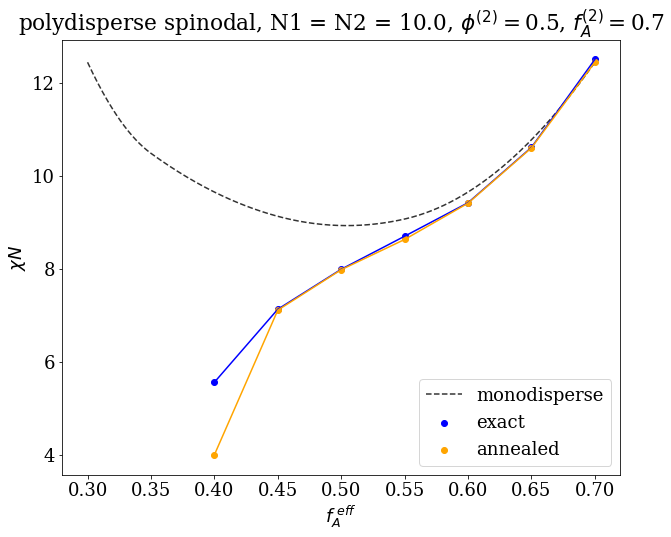

In [80]:
#FA EFF
matrixG2_spin_polyd_interp = interp1d(FA_1_arr, polyd_spinodal_arr, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic")
vertex_spin_interp_polyd_anneal = interp1d(FA_1_arr, spin_array_vertex_polyd_anneal*N_1, kind="quadratic")

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.300, 0.70, 0.001)

fa_eff = PHI_1 * new_x + PHI_2 * FA_2
# ax.plot(fa_eff, matrixG2_spin_polyd_interp(new_x), color = "blue", label = "exact", zorder = 0)
ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "black", linestyle = "--", label = "monodisperse", alpha = 0.8)
# ax.plot(fa_eff, vertex_spin_interp_polyd_anneal(new_x), color = "orange",  label = "annealed")

ax.scatter( PHI_1 * FA_1_arr + PHI_2 * FA_2, polyd_spinodal_arr, color = "blue", label = "exact")
# ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "black", label = "monodisperse", zorder = 1)
ax.scatter(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange", label = "annealed", zorder = 1)

ax.plot( PHI_1 * FA_1_arr + PHI_2 * FA_2, polyd_spinodal_arr, color = "blue")#, label = "exact")
ax.plot(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange")#, label = "annealed", zorder = 1)


plt.legend()
plt.title("polydisperse spinodal, N1 = N2 = " + str(N_1) + ", $\phi^{(2)} = $" + str(PHI_2) + ", $f_A^{(2)} = $" + str(FA_2))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\ eff}$")

# plt.ylim(10, 12.5)
# plt.xlim(0.3, 0.5)

In [ ]:
#F_A 1
matrixG2_spin_polyd_interp = interp1d(FA_1_arr, polyd_spinodal_arr, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic")
# vertex_spin_interp_polyd_anneal = interp1d(FA_1_arr, spin_array_vertex_polyd_anneal*N_1, kind="quadratic")

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.300, 0.50, 0.001)

ax.plot(new_x, matrixG2_spin_polyd_interp(new_x), color = "blue", label = "exact", zorder = 0)
ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "black", linestyle = "--", label = "monodisperse", alpha = 0.8)
# ax.plot(fa_eff, vertex_spin_interp_polyd_anneal(new_x), color = "orange",  label = "annealed")

# ax.scatter(FA_1_arr, polyd_spinodal_arr, color = "blue", label = "exact")
# ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "black", label = "monodisperse", zorder = 1)
# ax.scatter(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange", label = "annealed", zorder = 1)

plt.legend()
plt.title("polydisperse spinodal, N1 = N2 = " + str(N_1) + ", $\phi^{(2)} = $" + str(PHI_2) + ", $f_A^{(2)} = $" + str(FA_2))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{(1)}$")

# plt.ylim(10, 13)
# plt.xlim(0.3, 0.5)

In [86]:
M1 = np.array([[3, 4], [5, 6]])
M2 = np.array([[1, 2], [3, 4]])
matarr = np.array([M1, M2])
eigval, eigvec = np.linalg.eigh(matarr)
eigval[0]

array([-0.72015325,  9.72015325])

In [89]:
eigvalflat = eigval.flatten()
eigvalflat

array([-0.72015325,  9.72015325, -0.85410197,  5.85410197])

In [87]:
eigvec[0]

array([[-0.80229293,  0.59693053],
       [ 0.59693053,  0.80229293]])

In [ ]:
#old cells

In [ ]:
%%time
#single component G2 matrix stability analysis. ISSUE: needed to apply incompressibility

N_1 = 10.

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

FA_arr = np.arange(0.3, 0.71, 0.1)
chi_range = np.arange(8, 13, .01)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]
    for chi in chi_range:
        chi_spin_bool = False #means spinodal has not been reached
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2 #determinant of s2 matrix
            prefactor_1 = 1/(det_1*2)[0] #1/2 from taylor expansion, which remains after performing gaussian integral

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

            G2 = (1/N_1)*np.array([[s2inv_BB_1, -s2inv_AB_1 + 0.5*chi*N_1], [-s2inv_AB_1 + 0.5*chi*N_1, s2inv_AA_1]]) #single poly type
            
            eigvalues,eigvectors = np.linalg.eigh(G2)
            min_eig = np.min(eigvalues)
            if min_eig <= 0:
                chi_spin_bool = True
                break
#             if eigvalues[0] < 0 and eigvalues[1] < 0:
#                 chi_spin_bool = True
#                 break
    #         determ = np.linalg.det(G2)
    #         if determ <= 0 :

    #             chi_spin_bool = True
    #             break
        if chi_spin_bool == True:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

In [ ]:
%%time
#binary mix- incompressibility applied, 4x4 -> 3x3. ASSUMING SAME LENGTH. NON vectorized
#TODO- make for a range of F_A
N_1 = 10.
# FA_1 = 0.7
FA_1_arr = np.arange(0.3, 0.71, 0.1)
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.7
PHI_2 = 0.00001

k0 = 1e-2
kf = 1e2
nk = 50

chi_range = np.arange(5.5, 20, 0.001)/N_1

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

polyd_spinodal_arr = np.array([]) 

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]


    for chi in chi_range:
    #     print("chi: ", chi)
        chi_spin_bool = False #means spinodal has not been reached
        chiN = chi * N
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2
            prefactor_1 = 1/(det_1 * 2 * PHI_1)[0]

            det_2 = s2_AA_2[k_ind] * s2_BB_2[k_ind] - s2_AB_2[k_ind]**2
            prefactor_2 = 1/(det_2 * 2 * PHI_2)[0]

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

            s2inv_AA_2 = s2_2[0][k_ind][0]*prefactor_2
            s2inv_AB_2 = s2_2[1][k_ind][0]*prefactor_2
            s2inv_BB_2 = s2_2[2][k_ind][0]*prefactor_2

            G2 = [[s2inv_BB_1 - (chi*N_1) + s2inv_AA_2, -s2inv_AB_1 + s2inv_AA_2, -(chi*N_1) + s2inv_AB_2 + s2inv_AA_2], \
                  [-s2inv_AB_1 + s2inv_AA_2, s2inv_AA_1 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2], \
                  [-(chi*N_1) + s2inv_AB_2 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2, s2inv_BB_2 + 2*s2inv_AB_2 - (chi*N_1) + s2inv_AA_2]]

            eigvalues,eigvectors = np.linalg.eigh(G2)
            min_eig = np.min(eigvalues)
            if min_eig <= 0:
                chi_spin_bool = True
                break
        if chi_spin_bool == True:
            polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
            break

In [ ]:
%%time
#binary mix- Vectorized, ASSUMING SAME LENGTH but can handle different lengths- dont know how to deal with XN y-axis
#TODO- make for a range of F_A
N_1 = 10.
# FA_1 = 0.7
FA_1_arr = np.arange(0.3, 0.71, 0.1)
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.7
PHI_2 = 0.00001

k0 = 1e-2
kf = 1e2
nk = 50

# chi_range = np.arange(5.5, 20, 0.001)/N_1

chi_range = np.arange(7, 15, 0.01)/N_1

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

polyd_spinodal_arr = np.array([]) 

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]

    for chi in chi_range:
    #     print("chi: ", chi)
        chi_spin_bool = False #means spinodal has not been reached
        chiN = chi * N
        
        det_1_arr = s2_AA_1 * s2_BB_1 - s2_AB_1**2
        prefactor_1_arr = 1/(det_1_arr*2*PHI_1)
        
        det_2_arr = s2_AA_2 * s2_BB_2 - s2_AB_2**2
        prefactor_2_arr = 1/(det_2_arr*2*PHI_2)
        
        s2inv_AA_1_arr = s2_AA_1*prefactor_1_arr/N_1
        s2inv_AB_1_arr = s2_AB_1*prefactor_1_arr/N_1
        s2inv_BB_1_arr = s2_BB_1*prefactor_1_arr/N_1
        
        s2inv_AA_2_arr = s2_AA_2*prefactor_2_arr/N_2
        s2inv_AB_2_arr = s2_AB_2*prefactor_2_arr/N_2
        s2inv_BB_2_arr = s2_BB_2*prefactor_2_arr/N_2
        
        #matrix indices
        
        zero_zero = s2inv_BB_1_arr - (chi) + s2inv_AA_2_arr
        zero_one = -s2inv_AB_1_arr + s2inv_AA_2_arr
        zero_two = -(chi) + s2inv_AB_2_arr + s2inv_AA_2_arr
        
        one_zero = zero_one
        one_one = s2inv_AA_1_arr + s2inv_AA_2_arr
        one_two = s2inv_AB_2_arr + s2inv_AA_2_arr
        
        two_zero = zero_two
        two_one = one_two
        two_two = s2inv_BB_2_arr + 2*s2inv_AB_2_arr - (chi) + s2inv_AA_2_arr
        
        G2 = np.array([zero_zero, zero_one, zero_two, one_zero, one_one, one_two, two_zero, two_one, two_two]).T.reshape(len(k_vec), 3, 3)
        eigvalues,eigvectors = np.linalg.eigh(G2)
        eigvalues = np.concatenate(eigvalues)
        min_eig = np.min(eigvalues)
        if min_eig <= 0:
            chi_spin_bool = True
            break
    if chi_spin_bool == True:
        polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
#         for k_ind in range(len(k_vec)):
#             det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2
#             prefactor_1 = 1/(det_1 * 2 * PHI_1)[0]

#             det_2 = s2_AA_2[k_ind] * s2_BB_2[k_ind] - s2_AB_2[k_ind]**2
#             prefactor_2 = 1/(det_2 * 2 * PHI_2)[0]

#             s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
#             s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
#             s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

#             s2inv_AA_2 = s2_2[0][k_ind][0]*prefactor_2
#             s2inv_AB_2 = s2_2[1][k_ind][0]*prefactor_2
#             s2inv_BB_2 = s2_2[2][k_ind][0]*prefactor_2

#             G2 = [[s2inv_BB_1 - (chi*N_1) + s2inv_AA_2, -s2inv_AB_1 + s2inv_AA_2, -(chi*N_1) + s2inv_AB_2 + s2inv_AA_2], \
#                   [-s2inv_AB_1 + s2inv_AA_2, s2inv_AA_1 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2], \
#                   [-(chi*N_1) + s2inv_AB_2 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2, s2inv_BB_2 + 2*s2inv_AB_2 - (chi*N_1) + s2inv_AA_2]]

#             eigvalues,eigvectors = np.linalg.eigh(G2)
#             min_eig = np.min(eigvalues)
#             if min_eig <= 0:
#                 chi_spin_bool = True
#                 break
#         if chi_spin_bool == True:
#             polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
#             break
#NON VECT- 2min 52 sec
# VECT - 1min 15 sec

polyd_spinodal_arr